## Debugging the Grow mode

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [2]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

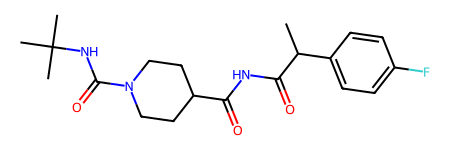

In [238]:
mols[0]

In [275]:
atom = mols[0].mol.GetAtoms()[0]
atom.GetProp('_protected')

KeyError: '_protected'

In [294]:
designer.design(mols[0], 5)

OrderedSet({<dgym.molecule.Molecule object at 0x7fc453362690>, <dgym.molecule.Molecule object at 0x7fc453362990>, <dgym.molecule.Molecule object at 0x7fc4533627d0>, <dgym.molecule.Molecule object at 0x7fc453363d50>, <dgym.molecule.Molecule object at 0x7fc453362190>})

In [429]:
gen = designer.generator(mols[0].reactants[1])

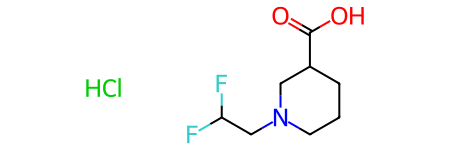

In [441]:
next(gen)

In [773]:
reactants = [
    designer.generator(mols[0].reactants[1]),
    [designer.generator(mols[0].reactants[0]), designer.generator(mols[0].reactants[1])] 
]

In [839]:
sample_preserving_structure(reactants)

In [829]:
from collections.abc import Iterable

def sample_preserving_structure(input_list):
    """
    Recursively processes an input list which can contain iterables (including generators),
    lists of iterables, or static objects. The function yields values from iterables
    while preserving the nested structure of the list.

    Parameters
    ----------
    input_list : list
        The input list which can contain iterables, lists, or static objects.

    Returns
    -------
    list
        A list with the same structure as `input_list`, where iterables
        have been replaced by their next value, and static objects are preserved.

    Examples
    --------
    >>> gen1 = (x for x in 'abc')
    >>> gen2 = (x for x in 'xyz')
    >>> input_list = [gen1, [gen2, 'static']]
    >>> sample_preserving_structure(input_list)
    ['a', ['x', 'static']]
    """
    def process_item(item):
        """Process a single item, recursively if it's a list."""
        if isinstance(item, Iterable) and not isinstance(item, (str, list)):
            return next(iter(item))
        elif isinstance(item, list):
            return [process_item(subitem) for subitem in item]
        else:
            return item

    return [process_item(item) for item in input_list]

In [ ]:
next(gen)

Viewable: <generator object LazyReaction.run at 0x7fc44fb9df10>

In [1030]:
designer.retrosynthesize(mols[0].reactants[0])

Viewable: <generator object LazyReaction.run at 0x7fc44ad56ce0>

In [1045]:
# next(mols[0].reactants[0].reaction.run(mols[0].reactants[0].reactants))

In [1046]:
# gen = designer.retrosynthesize(mols[0].reactants[0])
# next(gen)

In [499]:
designer.reset_cache()
new_mols = designer.design(mols[0], 5, temperature=0.0, mode='replace', replace=1)
print(new_mols)
# MolsToGridImage([m.mol for m in new_mols], molsPerRow=5)

OrderedSet(set())


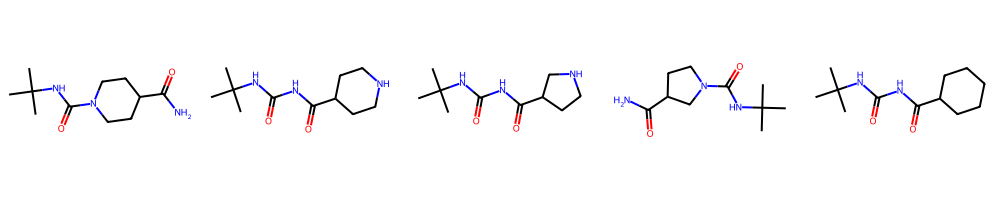

In [1066]:
from rdkit.Chem.Draw import MolsToGridImage

designer.reset_cache()
mols = designer.design(deck[1], 5, mode='replace')

MolsToGridImage([m.mol for m in mols], molsPerRow=5)